# Notebook de importação e Depuração dos datasets

#### Criação de um objeto spark

In [ ]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round, dayofweek, when, avg
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans


# build our SparkSession

spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [3]:
spark

#### Ler os datasets a usar

In [4]:
! ls -la ../Datasets/

total 1568508
drwxrwxrwx 1 root   root        4096 Jun 10 10:45 .
drwxrwxrwx 1 root   root        4096 Jun  4 15:45 ..
-rwxrwxrwx 1 root   root      130703 Jun  4 15:36 acorn_details.csv
-rwxrwxrwx 1 root   root  1251594914 Jun  4 15:30 archive.zip
drwxrwxrwx 1 root   root        4096 Jun  4 15:44 daily_dataset
-rwxrwxrwx 1 root   root   351799634 Jun  4 15:36 daily_dataset.csv
drwxr-xr-x 1 jovyan users       4096 Jun 10 10:46 energy_households_parquet.parquet
drwxrwxrwx 1 root   root        4096 Jun  4 15:44 halfhourly_dataset
drwxrwxrwx 1 root   root        4096 Jun  4 15:44 hhblock_dataset
-rwxrwxrwx 1 root   root      234595 Jun  4 15:38 informations_households.csv
-rwxrwxrwx 1 root   root         786 Jun  4 15:38 uk_bank_holidays.csv
-rwxrwxrwx 1 root   root      341198 Jun  4 15:38 weather_daily_darksky.csv
-rwxrwxrwx 1 root   root     2034495 Jun  4 15:38 weather_hourly_darksky.csv


In [5]:
# Diretório onde os arquivos estão localizados
diretorio = "../Datasets/"

# Leitura de todos os arquivos CSV no diretório
df_households = spark.read.options(header='True', inferSchema='True').csv(diretorio + "*informations_households" + "*.csv")
df_contagens = spark.read.options(header='True', inferSchema='True').csv(diretorio + "*daily_dataset" + "*.csv")


#### Exploração e limpeza dos datasets

##### Dataframe com a informação das casas

In [6]:
num_linhas = df_households.count()
num_colunas = len(df_households.columns)
print(f"O DataFrame tem {num_linhas} linhas e {num_colunas} colunas")

O DataFrame tem 5566 linhas e 5 colunas


In [7]:
# Visualização das primeiras 20 linhas do dataset com a informação relativa às casas
df_households.show()

+---------+--------+-------+-------------+-------+
|    LCLid|stdorToU|  Acorn|Acorn_grouped|   file|
+---------+--------+-------+-------------+-------+
|MAC005492|     ToU| ACORN-|       ACORN-|block_0|
|MAC001074|     ToU| ACORN-|       ACORN-|block_0|
|MAC000002|     Std|ACORN-A|     Affluent|block_0|
|MAC003613|     Std|ACORN-A|     Affluent|block_0|
|MAC003597|     Std|ACORN-A|     Affluent|block_0|
|MAC003579|     Std|ACORN-A|     Affluent|block_0|
|MAC003566|     Std|ACORN-A|     Affluent|block_0|
|MAC003557|     Std|ACORN-A|     Affluent|block_0|
|MAC003553|     Std|ACORN-A|     Affluent|block_0|
|MAC003482|     Std|ACORN-A|     Affluent|block_0|
|MAC003463|     Std|ACORN-A|     Affluent|block_0|
|MAC003449|     Std|ACORN-A|     Affluent|block_0|
|MAC003428|     Std|ACORN-A|     Affluent|block_0|
|MAC003423|     Std|ACORN-A|     Affluent|block_0|
|MAC003422|     Std|ACORN-A|     Affluent|block_0|
|MAC003400|     Std|ACORN-A|     Affluent|block_0|
|MAC003394|     Std|ACORN-A|   

In [8]:
df_households.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



##### Dataset com os registos das contagens energéticas

In [9]:
num_linhas = df_contagens.count()
num_colunas = len(df_contagens.columns)
print(f"O DataFrame com os registos energéticos tem {num_linhas} linhas e {num_colunas} colunas")

O DataFrame com or registos energéticos tem 3510433 linhas e 9 colunas


In [10]:
# Visualização das primeiras 20 linhas do dataset com os registos energéticos, relativos às casas
df_contagens.show()

+---------+----------+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|    LCLid|       day|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|         energy_min|
+---------+----------+-------------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|MAC000131|2011-12-15|              0.485|0.43204545454545457|             0.868|          22|0.23914579678767536|             9.505|0.07200000000000001|
|MAC000131|2011-12-16|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|              0.031|
|MAC000131|2011-12-17|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|              0.064|
|MAC000131|2011-12-18|              0.114| 0.2189791666666666|0.675999999999

In [11]:
df_contagens.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- day: date (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)



In [12]:
# Ajustar o tipo de variáveis
df_contagens = df_contagens.withColumn("day", to_date(col("day"), "yyyy-MM-dd"))
df_contagens = df_contagens.withColumn("energy_median", col("energy_median").cast("float"))
df_contagens = df_contagens.withColumn("energy_mean", col("energy_mean").cast("float"))
df_contagens = df_contagens.withColumn("energy_max", col("energy_max").cast("float"))
df_contagens = df_contagens.withColumn("energy_count", col("energy_count").cast("float"))
df_contagens = df_contagens.withColumn("energy_std", col("energy_std").cast("float"))
df_contagens = df_contagens.withColumn("energy_sum", col("energy_sum").cast("float"))
df_contagens = df_contagens.withColumn("energy_min", col("energy_min").cast("float"))

df_contagens.printSchema()
df_contagens.count()


root
 |-- LCLid: string (nullable = true)
 |-- day: date (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- energy_max: float (nullable = true)
 |-- energy_count: float (nullable = true)
 |-- energy_std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- energy_min: float (nullable = true)



3510433

In [13]:
# Ajustar as casas decimais das colunas numéricas
colunas_para_arredondar = ["energy_median", "energy_mean", "energy_max", "energy_count",
                            "energy_std", "energy_sum", "energy_min"]

for coluna in colunas_para_arredondar:
    df_contagens = df_contagens.withColumn(coluna, round(df_contagens[coluna], 3))

In [14]:
# Verificação dos valores omissos no dois datasets
print("No dataset df_households:")
for column in df_households.columns:
    null_count = df_households.filter(col(column).isNull()).count()
    print(f"A coluna {column} tem {null_count} valores nulos")

print("\n")
print("No dataset df_contagens")
for column in df_contagens.columns:
    null_count = df_contagens.filter(col(column).isNull()).count()
    print(f"A coluna {column} tem {null_count} valores nulos")

No dataset df_households:
A coluna LCLid tem 0 valores nulos
A coluna stdorToU tem 0 valores nulos
A coluna Acorn tem 0 valores nulos
A coluna Acorn_grouped tem 0 valores nulos
A coluna file tem 0 valores nulos


No dataset df_contagens
A coluna LCLid tem 0 valores nulos
A coluna day tem 0 valores nulos
A coluna energy_median tem 30 valores nulos
A coluna energy_mean tem 30 valores nulos
A coluna energy_max tem 30 valores nulos
A coluna energy_count tem 0 valores nulos
A coluna energy_std tem 11331 valores nulos
A coluna energy_sum tem 30 valores nulos
A coluna energy_min tem 30 valores nulos


In [15]:
# Eliminar as linhas com valores omissos 
df_contagens = df_contagens.dropna()
df_contagens.count()

3499102

In [16]:
# Eliminar linhas duplicadas
print(df_households.dropDuplicates().count())
print(df_contagens.dropDuplicates().count())

#Não havia linhas duplicadas

5566
3499102


#### Juntar os dois datasets

In [17]:
combined_datasets = df_contagens.join(df_households, df_contagens["LCLid"] == df_households["LCLid"], "left")

#Selecionar apenas as colunas relevantes
combined_datasets = combined_datasets.select(df_contagens["LCLid"], df_contagens["day"], df_contagens["energy_median"],
                                             df_contagens["energy_mean"],df_contagens["energy_max"], 
                                             df_contagens["energy_count"], df_contagens["energy_std"], 
                                             df_contagens["energy_sum"], df_contagens["energy_min"],
                                             df_households["stdorToU"], df_households["Acorn"], 
                                             df_households["Acorn_grouped"])


combined_datasets.show()
combined_datasets.count()

+---------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+-------+-------------+
|    LCLid|       day|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|stdorToU|  Acorn|Acorn_grouped|
+---------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+-------+-------------+
|MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|ACORN-E|     Affluent|
|MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|ACORN-E|     Affluent|
|MAC000131|2011-12-17|        0.101|       0.19|     0.685|        48.0|     0.188|     9.111|     0.064|     Std|ACORN-E|     Affluent|
|MAC000131|2011-12-18|        0.114|      0.219|     0.676|        48.0|     0.203|    10.511|     0.065|     Std|ACORN-E|     Affluent|
|MAC000131|2011-12-19|        0.191|     

3499102

## Mudar os nomes das variáveis para nomes mais representativos:

### Observação dos valores únicos

In [ ]:
# Selecionar as colunas acorn 
combined_datasets.select("Acorn").distinct().orderBy("Acorn", ascending=True).show(truncate=False)
combined_datasets.select("Acorn").distinct().count()

+-------+
|Acorn  |
+-------+
|ACORN- |
|ACORN-A|
|ACORN-B|
|ACORN-C|
|ACORN-D|
|ACORN-E|
|ACORN-F|
|ACORN-G|
|ACORN-H|
|ACORN-I|
|ACORN-J|
|ACORN-K|
|ACORN-L|
|ACORN-M|
|ACORN-N|
|ACORN-O|
|ACORN-P|
|ACORN-Q|
|ACORN-U|
+-------+



19

In [19]:
# Selecionar os tipos de Acorn_grouped
combined_datasets.select("Acorn_grouped").distinct().orderBy("Acorn", ascending=True).show(truncate=False)
combined_datasets.select("Acorn_grouped").distinct().count()

+-------------+
|Acorn_grouped|
+-------------+
|ACORN-       |
|Affluent     |
|Comfortable  |
|Adversity    |
|ACORN-U      |
+-------------+



5

In [20]:
# Observar os tipos de acorn_group por tipo de Acorn
combined_datasets.select("Acorn","Acorn_grouped").distinct().orderBy("Acorn", ascending=True).show(truncate=False)

+-------+-------------+
|Acorn  |Acorn_grouped|
+-------+-------------+
|ACORN- |ACORN-       |
|ACORN-A|Affluent     |
|ACORN-B|Affluent     |
|ACORN-C|Affluent     |
|ACORN-D|Affluent     |
|ACORN-E|Affluent     |
|ACORN-F|Comfortable  |
|ACORN-G|Comfortable  |
|ACORN-H|Comfortable  |
|ACORN-I|Comfortable  |
|ACORN-J|Comfortable  |
|ACORN-K|Adversity    |
|ACORN-L|Adversity    |
|ACORN-M|Adversity    |
|ACORN-N|Adversity    |
|ACORN-O|Adversity    |
|ACORN-P|Adversity    |
|ACORN-Q|Adversity    |
|ACORN-U|ACORN-U      |
+-------+-------------+



Após a observação dos valores únicos de cada coluna Acorn, concluímos que os Acorn referem-se a tipos específicos de consumo, os acorn groups, classificados de acordo com os valores definidos oficialmente (?).
Assim, preferimos manter esta variável e eliminar os cluster mais gerais, e fazer nós próprios a clusterização.
O nome da variável acorn vai, então, ser atualizado de acordo. Passará a ser "acorn_groups".

#### Alteração dos nomes das variáveis para nomes mais representativos

In [21]:
df_variables_renamed = combined_datasets.withColumnRenamed('LCLid', 'household_id')\
       .withColumnRenamed('day', 'date')\
       .withColumnRenamed('stdorToU', 'tax_type')\
       .withColumnRenamed('Acorn', 'acorn_groups')\
       .withColumnRenamed('Acorn_grouped', 'status')

In [22]:
df_variables_renamed.show()

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|
|   MAC000131|2011-12-17|        0.101|       0.19|     0.685|        48.0|     0.188|     9.111|     0.064|     Std|     ACORN-E|Affluent|
|   MAC000131|2011-12-18|        0.114|      0.219|     0.676|        48.0|     0.203|    10.511|     0.065|     Std|     ACORN-E|Affluent|
|   MAC000131|2011-1

In [23]:
# Separar a variável "date" em dias, meses, anos, dias da semana e semanas do ano
df_new_cols = ( df_variables_renamed
                .withColumn("date_YEAR", F.year("date"))
                .withColumn("date_MONTH", F.month("date"))
                .withColumn("date_DAY_OF_WEEK", F.dayofweek("date"))
                .withColumn("date_WEEK_OF_YEAR",F.weekofyear("date"))
                )

In [24]:
df_new_cols.show(5)

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|     2011|        12|               5|               50|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|     2011|        12|               6|               50|
|   MAC000131|2011-1

Tratamento da ACORN- (ACORN não identificado)

In [25]:
# Filtrar as linhas onde a coluna acorn_groups é igual a 'Acorn-'
acorn_count = df_new_cols.filter(df_new_cols.acorn_groups == 'ACORN-').count()

print(f"O número de elementos igual a 'ACORN-' é: {acorn_count}")

percentagem = 777*100/df_new_cols.count()

print('A percentagem de valores ACORN-, face ao número de linhas da base de dados é', percentagem, '%')

O número de elementos igual a 'ACORN-' é: 777
A percentagem de valores ACORN-, face ao número de linhas da base de dados é 0.22205697347490871 %


Visto a quantidade de valores ACORN- ser bastante reduzida em comparação com a quantidade de valores da base de dados, decidimos eliminar a variável.

In [26]:
df_new_cols.filter(df_new_cols.acorn_groups == 'Acorn-')
no_acornTBD_df = df_new_cols.filter( df_new_cols.acorn_groups != 'ACORN-' )

no_acornTBD_df.show()

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|     2011|        12|               5|               50|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|     2011|        12|               6|               50|
|   MAC000131|2011-1

In [27]:
#Visualização do resultado:

no_acornTBD_df.select("acorn_groups").distinct().orderBy("acorn_groups",ascending=True).show(truncate=False)


+------------+
|acorn_groups|
+------------+
|ACORN-A     |
|ACORN-B     |
|ACORN-C     |
|ACORN-D     |
|ACORN-E     |
|ACORN-F     |
|ACORN-G     |
|ACORN-H     |
|ACORN-I     |
|ACORN-J     |
|ACORN-K     |
|ACORN-L     |
|ACORN-M     |
|ACORN-N     |
|ACORN-O     |
|ACORN-P     |
|ACORN-Q     |
|ACORN-U     |
+------------+



#### Criação de dummies

In [28]:
dummie_df = no_acornTBD_df

##### Criação de uma coluna dummie que identifique se é fim de semana (1) ou não (0)

In [29]:
# Agregar por mês para obter o consumo médio
dummie_df_cunsumo_medio = dummie_df.groupBy('date_MONTH').agg(
    avg("energy_max").alias("avg_energy_max"),
    avg("energy_mean").alias("avg_energy_mean")
).orderBy('date_MONTH')
dummie_df_pandas = dummie_df_cunsumo_medio.toPandas()

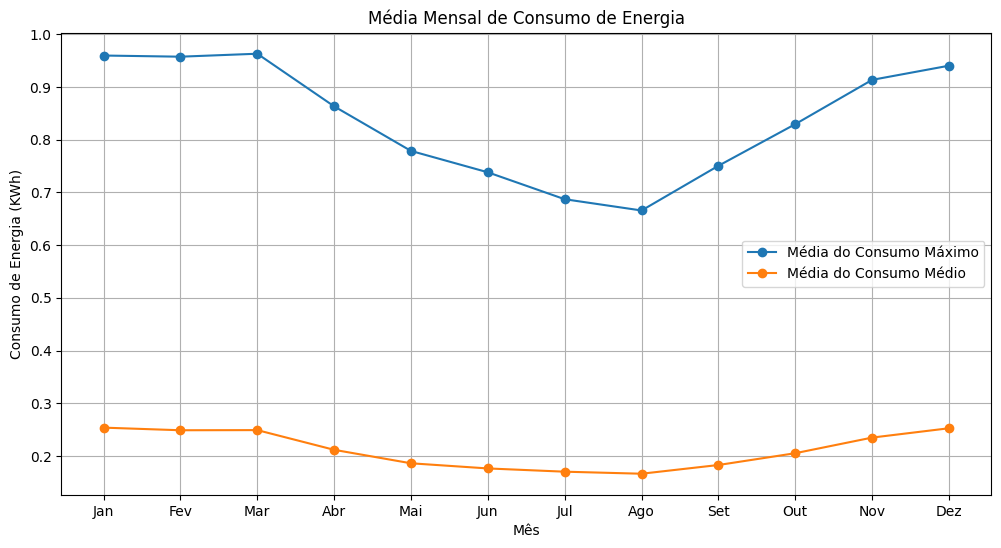

In [30]:
# Criação dum gráfico simples para visualizar padrões
plt.figure(figsize=(12, 6))
plt.plot(dummie_df_pandas['date_MONTH'], dummie_df_pandas['avg_energy_max'], label='Média do Consumo Máximo', marker='o')
plt.plot(dummie_df_pandas['date_MONTH'], dummie_df_pandas['avg_energy_mean'], label='Média do Consumo Médio', marker='o')
plt.title('Média Mensal de Consumo de Energia')
plt.xlabel('Mês')
plt.ylabel('Consumo de Energia (KWh)')
plt.xticks(range(1, 13), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Calcular e observar a correlação
correlation = dummie_df_pandas['avg_energy_max'].corr(dummie_df_pandas['avg_energy_mean'])
print("Correlação entre Consumo Máximo e Médio:", correlation)

Correlação entre Consumo Máximo e Médio: 0.9868636562520278


In [32]:
#Calcular médias para comparação
from statsmodels.tsa.stattools import adfuller

#Teste Dickey-Fuller aumentado para verificar estacionalidade
adf_test_max = adfuller(dummie_df_pandas['avg_energy_max'])
adf_test_mean = adfuller(dummie_df_pandas['avg_energy_mean'])

print('ADF Statistic for max energy:', adf_test_max[0])
print('p-value for max energy:', adf_test_max[1])
print('ADF Statistic for mean energy:', adf_test_mean[0])
print('p-value for mean energy:', adf_test_mean[1])

ADF Statistic for max energy: -1.572364001974744
p-value for max energy: 0.4974593916153193
ADF Statistic for mean energy: -4.129178719547443
p-value for mean energy: 0.0008663817232768774


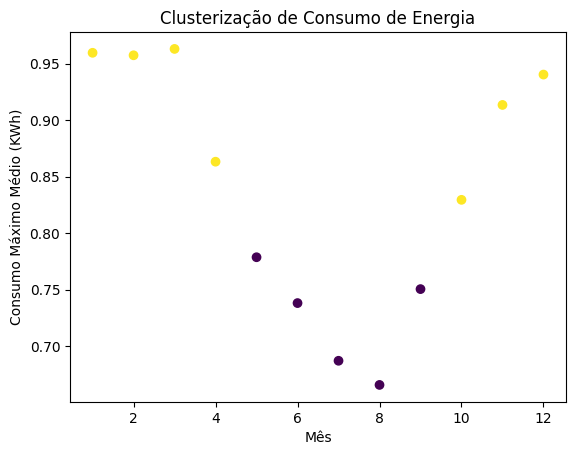

In [33]:
#Aplicar K-Means para agrupar meses
kmeans = KMeans(n_clusters=2, random_state=0).fit(dummie_df_pandas[['avg_energy_max', 'avg_energy_mean']])
dummie_df_pandas['cluster'] = kmeans.labels_

#Visualizando os clusters
plt.scatter(dummie_df_pandas['date_MONTH'], dummie_df_pandas['avg_energy_max'], c=dummie_df_pandas['cluster'])
plt.title('Clusterização de Consumo de Energia')
plt.xlabel('Mês')
plt.ylabel('Consumo Máximo Médio (KWh)')
plt.show()

Ficou decidido que seriam definidos como meses de verão entre maio e setembro

In [34]:
dummie_df = dummie_df.withColumn("is_summer", when(col("date_MONTH").isin([5, 6, 7, 8, 9]), 1).otherwise(0)) 
dummie_df.show(5)

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|is_summer|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|     2011|        12|               5|               50|        0|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|     2011|        12|               6

##### Criar uma coluna dummie para indicar se é fim de semana, para eliminar essas linhas

In [35]:
dummie_df = dummie_df.withColumn("is_weekend", when(col("date_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0)) 

#Eliminar as linhas identificadas como fim de semana
dummie_df = dummie_df.filter(col("is_weekend")==0)

#Eliminar a coluna após a filtragem
dummie_df = dummie_df.drop('is_weekend')

#### Eliminar os feriados da base de dados

In [36]:
# Importar a base de dados com os feriados
df_feriados = spark.read.options(header='True', inferSchema='True').csv(diretorio + "*uk_bank_holidays" + "*.csv")
df_feriados.show(5)

+-------------+--------------------+
|Bank holidays|                Type|
+-------------+--------------------+
|   2012-12-26|          Boxing Day|
|   2012-12-25|       Christmas Day|
|   2012-08-27| Summer bank holiday|
|   2012-05-06|Queen?s Diamond J...|
|   2012-04-06|Spring bank holid...|
+-------------+--------------------+
only showing top 5 rows



In [37]:
df_feriados.select('Type').distinct().show()

+--------------------+
|                Type|
+--------------------+
|          Boxing Day|
| Summer bank holiday|
|Queen?s Diamond J...|
|       Christmas Day|
|         Good Friday|
|Spring bank holid...|
|New Year?s Day (s...|
|       Easter Monday|
|Early May bank ho...|
|      New Year?s Day|
| Spring bank holiday|
+--------------------+



In [38]:
## Juntar os dois datasets para remover as leituras de feriados
leituras_e_feriados = dummie_df.join(df_feriados, dummie_df["date"] == df_feriados["Bank holidays"], "left")

# Retirar a coluna 'Bank Holidays'
leituras_e_feriados = leituras_e_feriados.drop('Bank holidays')

# Mudar o nome da variável 'Type' para 'Holiday'
leituras_e_feriados = leituras_e_feriados.withColumnRenamed('Type', 'Holiday')
leituras_e_feriados.show(3)

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+-------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|is_summer|Holiday|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+-------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|     2011|        12|               5|               50|        0|   NULL|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|     

In [39]:
leituras_e_feriados.select('Holiday').distinct().show()

+--------------------+
|             Holiday|
+--------------------+
| Summer bank holiday|
|          Boxing Day|
|         Good Friday|
|       Christmas Day|
|New Year?s Day (s...|
|Spring bank holid...|
|       Easter Monday|
|Early May bank ho...|
|      New Year?s Day|
| Spring bank holiday|
|                NULL|
+--------------------+



In [40]:
## Seleção apenas das linhas que não são feriados
leituras_sem_feriados = leituras_e_feriados.filter(col("Holiday").isNull())

count_antes = leituras_e_feriados.count()
count_depois = leituras_sem_feriados.count()
print(count_antes)
print(count_depois)
print(f"Ocorreu uma diminuição de ", count_antes-count_depois, "o que representa uma diferença de ", ((count_depois-count_antes)/count_antes)*100, '%')

2501525
2423320
Ocorreu uma diminuição de  78205 o que representa uma diferença de  -3.126292961293611 %


In [41]:
# Eliminar a coluna 'Holiday'
leituras_sem_feriados = leituras_sem_feriados.drop('Holiday')
leituras_sem_feriados.show(3)

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|  status|date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|is_summer|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+--------+---------+----------+----------------+-----------------+---------+
|   MAC000131|2011-12-15|        0.485|      0.432|     0.868|        22.0|     0.239|     9.505|     0.072|     Std|     ACORN-E|Affluent|     2011|        12|               5|               50|        0|
|   MAC000131|2011-12-16|        0.141|      0.296|     1.116|        48.0|     0.281|    14.216|     0.031|     Std|     ACORN-E|Affluent|     2011|        12|               6

#### Guardar o ficheiro localmente em parquet

In [42]:
# Criação de partições para aumentar o paralelismo
energy_households = leituras_sem_feriados.repartition(200)
energy_households.show(truncate= False)

+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+-----------+---------+----------+----------------+-----------------+---------+
|household_id|date      |energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|tax_type|acorn_groups|status     |date_YEAR|date_MONTH|date_DAY_OF_WEEK|date_WEEK_OF_YEAR|is_summer|
+------------+----------+-------------+-----------+----------+------------+----------+----------+----------+--------+------------+-----------+---------+----------+----------------+-----------------+---------+
|MAC000965   |2013-09-25|0.097        |0.171      |1.251     |48.0        |0.219     |8.227     |0.044     |ToU     |ACORN-H     |Comfortable|2013     |9         |4               |39               |1        |
|MAC000019   |2012-08-14|0.079        |0.093      |0.578     |48.0        |0.078     |4.462     |0.025     |Std     |ACORN-K     |Adversity  |2012     |8         |3

In [43]:
# Salvar a base de dados em parquet
path = '../Datasets/energy_households_parquet.parquet'
energy_households.write.mode("overwrite").parquet(path)